# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection  import GridSearchCV

%matplotlib inline

# read in the json files
portfolio = pd.read_json('../data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('../data/profile.json', orient='records', lines=True)
transcript = pd.read_json('../data/transcript.json', orient='records', lines=True)

In [2]:
# Understand the data
portfolio.head(20)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
profile.head(20)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


# Profile comments
We can see that there are a lot of clients with age 118, where the Gender and Income is NaN. Probably these clients have not filled in their account details yet and are given a default value.

In [4]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [5]:
eventFrequencies = transcript.groupby('person').count().sort_values(by='event',ascending=False)
eventFrequencies.describe()

,event,value,time
count,17000.000000,17000.000000,17000.000000
mean,18.031412,18.031412,18.031412
std,6.849595,6.849595,6.849595
min,1.000000,1.000000,1.000000
25%,13.000000,13.000000,13.000000
50%,17.000000,17.000000,17.000000
75%,23.000000,23.000000,23.000000
max,51.000000,51.000000,51.000000


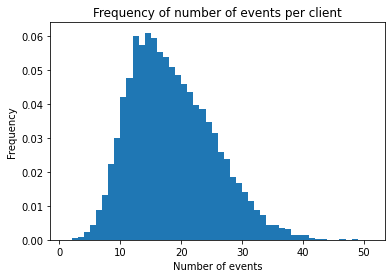

In [6]:
plt.hist(eventFrequencies['event'],bins = 50, density=True)
plt.xlabel('Number of events')
plt.ylabel('Frequency')
plt.title('Frequency of number of events per client');


In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
#See distribution of genders
profile.groupby('gender').count()

,age,id,became_member_on,income
gender,,,,
F,6129,6129,6129,6129
M,8484,8484,8484,8484
O,212,212,212,212


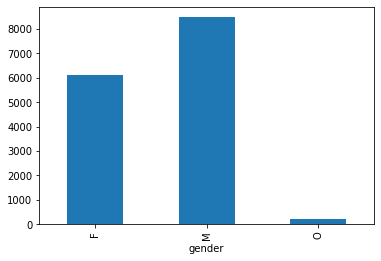

In [9]:
profile.groupby('gender').count()['age'].plot(kind='bar');

In [10]:
profile.groupby('age').count()

,gender,id,became_member_on,income
age,,,,
18,70,70,70,70
19,135,135,135,135
20,135,135,135,135
21,140,140,140,140
22,131,131,131,131
...,...,...,...,...
98,5,5,5,5
99,5,5,5,5
100,12,12,12,12


In [11]:
clientsbyAge = profile.groupby('age').count()['gender']
clientsbyAge.head()

age
18     70
19    135
20    135
21    140
22    131
Name: gender, dtype: int64

Text(0.5, 1.0, 'Distribution of clients by age')

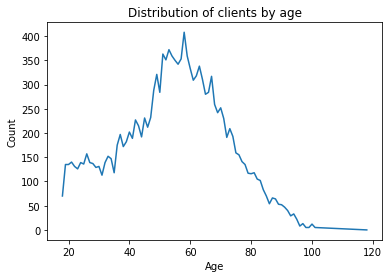

In [12]:
plt.plot(clientsbyAge)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of clients by age')

In [13]:
#See a typical persons transaction log
transcript[transcript['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


# Transform transcripts to actual campaign outcomes
We have all the events/transactions for each user. We now need to transform this into something useful. The main idea is to have the outcome for each campaign and user. Was it completed, viewed, completed? How much money was spent during the valid period of the campaign?

## Start with an offer
We take all transactions for one particular user. Then we looks for the first offer that was received. We then follow the coming events to see what actually happened. When the offer expires or the user completes the offer, we save those metrics and move to the next campaign.

We then do this for all users and build up a new dataset that can be used for further analysis.

In [14]:
#Reset all vectors to null
personIdVect = []
offerIdVect = []
offerViewVect = []
offerCompletedVect = []
amountVect = []
durationDaysVect = []
offerTypeVect = []
offersViewedCountVect = []
offersCompletedCountVect = []
amountSpentVect = []
offersReceivedCountVect = []

#Extract all personIds
persons = transcript['person'].unique()
transcript['value'].astype(str) 
personCount = 0

print('Data mining started...')
for personId in persons:
    #Get all transactions for a particular user
    eventsForPerson = transcript[transcript['person'] == personId]
    
    amountSpent = 0.0
    offersCompletedCount = 0
    offersViewedCount = 0
    offersReceivedCount = 0
    
    #Move through the transactions/events for that person
    for index, row in eventsForPerson.iterrows():
        
        #Sum up the total amount spent by this user up to now
        if row['event'] == 'transaction':
            amountSpent += row['value']['amount']
            
        if row['event'] == 'offer received':
            #We have a new offer, lets follow up what happened
            offerId = row['value']['offer id']
            offerStart = row['time']

            durationDays = portfolio[portfolio['id'] == offerId]['duration'].iloc[0]
            offerType = portfolio[portfolio['id'] == offerId]['offer_type'].iloc[0]

            duration = 24*durationDays #Duration of offer in hours
            offerViewed = False
            offerCompleted = False
            amountDuringOffer = 0.0


            #Start from the next event after an offer has been received:
            for _, rowAfterOffer in eventsForPerson.loc[index + 1:].iterrows():
                
                timeNow = rowAfterOffer['time']
                dt = timeNow - offerStart
                if dt <= duration:
                    #We are within the offer validity period
                   
                    #Check if the offer was viewed
                    if rowAfterOffer['event'] == 'offer viewed' and rowAfterOffer['value']['offer id'] == offerId:
                        #The offer was viewed
                        offerViewed = True                        

                    #Check if offer was completed
                    if  rowAfterOffer['event'] == 'offer completed' and offerId in str(rowAfterOffer['value']):
                        #The offer was completed
                        offerCompleted = True                        

                    #Sum up the amount during the campaign period
                    if rowAfterOffer['event'] == 'transaction':
                        amountDuringOffer += rowAfterOffer['value']['amount']

                else:
                    #Offer expired, no need to look further
                    break

            personIdVect.append(personId)
            offerIdVect.append(offerId)
            offerViewVect.append(offerViewed)
            offerCompletedVect.append(offerCompleted)
            amountVect.append(amountDuringOffer)            
            durationDaysVect.append(durationDays)
            offerTypeVect.append(offerType)            
            offersReceivedCountVect.append(offersReceivedCount)
            offersViewedCountVect.append(offersViewedCount)
            offersCompletedCountVect.append(offersCompletedCount)
            amountSpentVect.append(amountSpent)
            
            
            #Update the users overall values
            if offerCompleted:
                offersCompletedCount +=1
                
            if offerViewed:
                offersViewedCount +=1

            offersReceivedCount += 1
            
    personCount +=1
    
    if personCount % 850 == 0:
        print(f'Progress: {np.round(100*personCount / len(persons), 2)}%')       
        
        
print('Done creating dataset...')

#Create a dataframe
offerOutcomes = pd.DataFrame({'personId': personIdVect,
                              'offerId': offerIdVect,
                              'offerViewed': offerViewVect,
                              'offerCompleted': offerCompletedVect,
                              'amountDuringOffer': amountVect,
                              'duration': durationDaysVect,
                              'offerType': offerTypeVect,
                              'offersPreviouslyReceived':offersReceivedCountVect,
                              'offersPreviouslyViewed': offersViewedCountVect,
                              'offersPreviouslyCompleted': offersCompletedCountVect,
                              'amountPreviouslySpent': amountSpentVect
                             })


Data mining started...
Progress: 5.0%
Progress: 10.0%
Progress: 15.0%
Progress: 20.0%
Progress: 25.0%
Progress: 30.0%
Progress: 35.0%
Progress: 40.0%
Progress: 45.0%
Progress: 50.0%
Progress: 55.0%
Progress: 60.0%
Progress: 65.0%
Progress: 70.0%
Progress: 75.0%
Progress: 80.0%
Progress: 85.0%
Progress: 90.0%
Progress: 95.0%
Progress: 100.0%
Done creating dataset...


# offerOutcomes dataset
We now have a dataset where we can follow every single person and their interactions with each campaign. We can for example see if the offer was viewed, if it was completed and how much money was spent during the campaign.

Also we keep track of how many offers the user has previously interacted with. This is useful when doing predictions later of how well a particular client will respond to future offers.

In [15]:
# View the result
offerOutcomes.head(20)         

,personId,offerId,offerViewed,offerCompleted,amountDuringOffer,duration,offerType,offersPreviouslyReceived,offersPreviouslyViewed,offersPreviouslyCompleted,amountPreviouslySpent
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True,37.67,7,bogo,0,0,0,0.00
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,True,False,49.39,3,informational,1,1,1,37.67
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,True,True,48.28,7,bogo,2,2,1,110.99
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,True,True,48.28,5,bogo,3,3,2,110.99
4,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,False,1.09,10,discount,0,0,0,0.00
5,a03223e636434f42ac4c3df47e8bac43,3f207df678b143eea3cee63160fa8bed,True,False,0.00,4,informational,1,1,0,4.59
6,a03223e636434f42ac4c3df47e8bac43,5a8bc65990b245e5a138643cd4eb9837,False,False,0.00,3,informational,2,2,0,4.59
7,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,False,0.06,10,discount,3,2,0,4.59
8,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,False,0.06,10,discount,4,3,0,4.59
9,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,True,False,0.00,7,discount,0,0,0,0.00


In [16]:
offersCount = offerOutcomes.shape[0]
offersViews = np.sum(offerOutcomes['offerViewed'])
offersCompleted = np.sum(offerOutcomes['offerCompleted'])
print(f'Number of offers: {offersCount}')
print(f'Number of offers viewed: {offersViews}')
print(f'Number of offers completed: {offersCompleted}')

Number of offers: 76277
Number of offers viewed: 56895
Number of offers completed: 33631


In [17]:
#Performance of different offer types
offerOutcomes.groupby('offerType').sum()

,offerViewed,offerCompleted,amountDuringOffer,duration,offersPreviouslyReceived,offersPreviouslyViewed,offersPreviouslyCompleted,amountPreviouslySpent
offerType,,,,,,,,
bogo,25372,15669,808643.32,183165,57043,42656,24896,1337470.78
discount,21559,17962,1068233.20,259596,57189,42815,24748,1319063.87
informational,9964,0,210286.72,53322,28596,21397,12494,685653.54


In [18]:
#Averages by offer type
offerOutcomes.groupby('offerType').mean()

,offerViewed,offerCompleted,amountDuringOffer,duration,offersPreviouslyReceived,offersPreviouslyViewed,offersPreviouslyCompleted,amountPreviouslySpent
offerType,,,,,,,,
bogo,0.831896,0.513755,26.513765,6.005607,1.870324,1.398603,0.816289,43.852939
discount,0.705857,0.588089,34.974731,8.499362,1.872409,1.401794,0.810267,43.187109
informational,0.654020,0.000000,13.802870,3.499967,1.876994,1.404463,0.820085,45.005155


# Feature engineering
Lets create features for each user and see if we can predict the outcome of the campaigns based on the user profile.

In [19]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [20]:
#Copy raw data
userFeatures = profile.copy()

#Remove duplicates, if there are any
userFeatures.drop_duplicates(inplace=True)

In [21]:
#One hot encode gender
userFeatures['isFemale'] = (userFeatures['gender'] == "F").astype(int)
userFeatures['isMale'] = (userFeatures['gender'] == "M").astype(int)
userFeatures['genderUnknown'] = (userFeatures['gender'].isna()).astype(int)

#Age has a default value of 118 if information was missing. Lets fix that

#First replace 118 with None if we think it is due to missing client information
userFeatures.loc[((userFeatures['age'] == 118) & (userFeatures['gender'].isna())), 'age'] = None

#Next impute age and income by the median value
userFeatures.fillna(userFeatures.median(numeric_only=True), inplace=True)

#Drop unused columns
userFeatures.drop(columns=['gender', 'became_member_on'], inplace=True)

#Rename id to personId
userFeatures.rename(columns={'id':'personId'}, inplace=True)

In [22]:
userFeatures.head(22)

,age,personId,income,isFemale,isMale,genderUnknown
0,55.0,68be06ca386d4c31939f3a4f0e3dd783,64000.0,0,0,1
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0
2,55.0,38fe809add3b4fcf9315a9694bb96ff5,64000.0,0,0,1
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0
4,55.0,a03223e636434f42ac4c3df47e8bac43,64000.0,0,0,1
5,68.0,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0
6,55.0,8ec6ce2a7e7949b1bf142def7d0e0586,64000.0,0,0,1
7,55.0,68617ca6246f4fbc85e91a2a49552598,64000.0,0,0,1
8,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0
9,55.0,8974fc5686fe429db53ddde067b88302,64000.0,0,0,1


In [23]:
# join the two datasets together
offersWithFeatures = offerOutcomes.merge(userFeatures, on='personId', how='left')
offersWithFeatures.head(10)

,personId,offerId,offerViewed,offerCompleted,amountDuringOffer,duration,offerType,offersPreviouslyReceived,offersPreviouslyViewed,offersPreviouslyCompleted,amountPreviouslySpent,age,income,isFemale,isMale,genderUnknown
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True,37.67,7,bogo,0,0,0,0.00,75.0,100000.0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,True,False,49.39,3,informational,1,1,1,37.67,75.0,100000.0,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,True,True,48.28,7,bogo,2,2,1,110.99,75.0,100000.0,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,True,True,48.28,5,bogo,3,3,2,110.99,75.0,100000.0,1,0,0
4,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,False,1.09,10,discount,0,0,0,0.00,55.0,64000.0,0,0,1
5,a03223e636434f42ac4c3df47e8bac43,3f207df678b143eea3cee63160fa8bed,True,False,0.00,4,informational,1,1,0,4.59,55.0,64000.0,0,0,1
6,a03223e636434f42ac4c3df47e8bac43,5a8bc65990b245e5a138643cd4eb9837,False,False,0.00,3,informational,2,2,0,4.59,55.0,64000.0,0,0,1
7,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,False,0.06,10,discount,3,2,0,4.59,55.0,64000.0,0,0,1
8,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,False,0.06,10,discount,4,3,0,4.59,55.0,64000.0,0,0,1
9,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,True,False,0.00,7,discount,0,0,0,0.00,68.0,70000.0,0,1,0


In [24]:
#Onehot encode the offer types
offersWithFeatures['isBogoOffer']  = (offersWithFeatures['offerType'] == 'bogo').astype(int)
offersWithFeatures['isInformationalOffer']  = (offersWithFeatures['offerType'] == 'informational').astype(int)
offersWithFeatures['isDiscountOffer']  = (offersWithFeatures['offerType'] == 'discount').astype(int)
offersWithFeatures.drop(columns=['offerType'], inplace=True)


In [25]:
offersWithFeatures.head()

,personId,offerId,offerViewed,offerCompleted,amountDuringOffer,duration,offersPreviouslyReceived,offersPreviouslyViewed,offersPreviouslyCompleted,amountPreviouslySpent,age,income,isFemale,isMale,genderUnknown,isBogoOffer,isInformationalOffer,isDiscountOffer
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True,37.67,7,0,0,0,0.00,75.0,100000.0,1,0,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,True,False,49.39,3,1,1,1,37.67,75.0,100000.0,1,0,0,0,1,0
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,True,True,48.28,7,2,2,1,110.99,75.0,100000.0,1,0,0,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,True,True,48.28,5,3,3,2,110.99,75.0,100000.0,1,0,0,1,0,0
4,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,False,1.09,10,0,0,0,0.00,55.0,64000.0,0,0,1,0,0,1


# Predict future campaign outcomes
Now we have a solid understanding of the data. Lets try and use machine learning to predict how a particular user will respond to a campaign. We user our features as inputs, such as age, income, gender, previous interactions etc. Then we try and predict if the user will complete the offer or not.

In [26]:
# Create inputs and targets
X = offersWithFeatures.drop(columns = ['personId', 'offerId', 'offerViewed', 'offerCompleted', 'amountDuringOffer'])
y = offersWithFeatures[['offerCompleted']].astype(int).to_numpy().reshape(-1,)
X.head()

,duration,offersPreviouslyReceived,offersPreviouslyViewed,offersPreviouslyCompleted,amountPreviouslySpent,age,income,isFemale,isMale,genderUnknown,isBogoOffer,isInformationalOffer,isDiscountOffer
0,7,0,0,0,0.00,75.0,100000.0,1,0,0,1,0,0
1,3,1,1,1,37.67,75.0,100000.0,1,0,0,0,1,0
2,7,2,2,1,110.99,75.0,100000.0,1,0,0,1,0,0
3,5,3,3,2,110.99,75.0,100000.0,1,0,0,1,0,0
4,10,0,0,0,0.00,55.0,64000.0,0,0,1,0,0,1


In [27]:
y

array([1, 0, 1, ..., 1, 0, 0])

In [28]:
# Split the data into train and test sets, to be able to evaluate the model on unseen data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [29]:
# Create a Bradient Boosting classifier 
clf = GradientBoostingClassifier(n_estimators=150, learning_rate=1.0, max_depth=3, random_state=42).fit(X_train, y_train)

In [30]:
print('Hit rate on test set:')
clf.score(X_test, y_test)

Hit rate on test set:


0.7912296801258522

In [31]:
print('Hit rate on train set:')
clf.score(X_train, y_train)

Hit rate on train set:


0.8169646515134135

In [32]:
preds = clf.predict(X_test)

In [33]:
# Example of predictions vs reality
predsDf = pd.DataFrame({'predictions': preds, 'reality': y_test})
predsDf.head(20)

,predictions,reality
0,0,1
1,0,0
2,0,0
3,0,1
4,0,0
5,1,1
6,1,1
7,0,0
8,1,1
9,0,0


# Confusion Matrix
A confusion matrix is a great way to visualize how good the predictions are. We can see where the model makes its errors. Is it false positives or false negatives that are most common? Lets have a look.

In [34]:
#Create a confusion matrix to view the results
cm = confusion_matrix(y_test, preds, labels=[0, 1] , normalize='all' )
print(cm)

[[0.44500524 0.11425013]
 [0.09452019 0.34622444]]


In [35]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [36]:
print(f'True Negatives: {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives: {tp}')


True Negatives: 6789
False Positives: 1743
False Negatives: 1442
True Positives: 5282


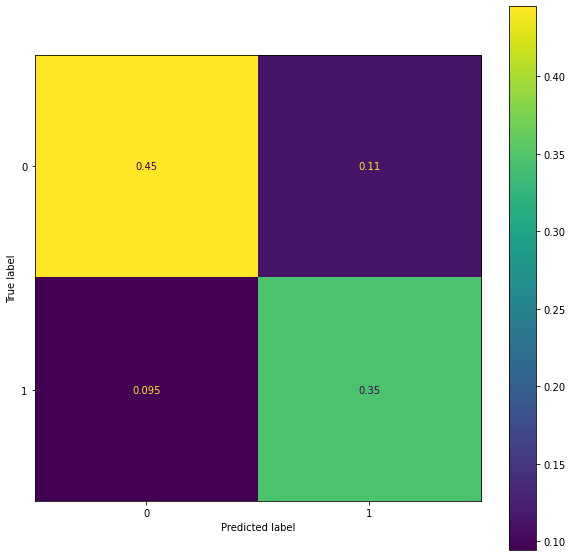

In [37]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show();

# Classification Report
Also we want to look at the [precission recall](https://en.wikipedia.org/wiki/Precision_and_recall) and the [F-score](https://en.wikipedia.org/wiki/F-score). The F-score is a good way of measuring the accuracy of the model even if the classes are not evenly distributed.

In [47]:
 print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      8532
           1       0.75      0.79      0.77      6724

    accuracy                           0.79     15256
   macro avg       0.79      0.79      0.79     15256
weighted avg       0.79      0.79      0.79     15256



# Improve model by tuning hyper parameters
We can use a grid search to improve the hyper parameters of the ML-model. A good way to do this is a grid search using cross validation. We start by setting up the parameter range we would like to test, and then the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) kan evaluate all permutations and find the best one.

Lets try that.

In [50]:
parameters = {
    'n_estimators':[100,150,200,500,1000,5000],
    'learning_rate':[0.1, 0.5, 1.0, 1.5],
    'max_depth':[2, 3, 4, 5, 10],
}

#clf = GradientBoostingClassifier(n_estimators=150, learning_rate=1.0, max_depth=3, random_state=42).fit(X_train, y_train)
cv = GridSearchCV(estimator = GradientBoostingClassifier(random_state=42), param_grid=parameters, n_jobs=-1, verbose=2, scoring='f1_weighted')
cv.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 78.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_n...e,
               

In [51]:
cv

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_n...e,
               

In [52]:
#Get information about the best estimator found
cv.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
#Evaluate the new estimator and see if it was better

In [53]:
preds = cv.predict(X_test)

In [54]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81      8532
           1       0.75      0.80      0.78      6724

    accuracy                           0.80     15256
   macro avg       0.80      0.80      0.80     15256
weighted avg       0.80      0.80      0.80     15256



In [55]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [56]:
print(f'True Negatives: {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives: {tp}')


True Negatives: 6779
False Positives: 1753
False Negatives: 1326
True Positives: 5398


[[0.44434976 0.11490561]
 [0.08691662 0.353828  ]]


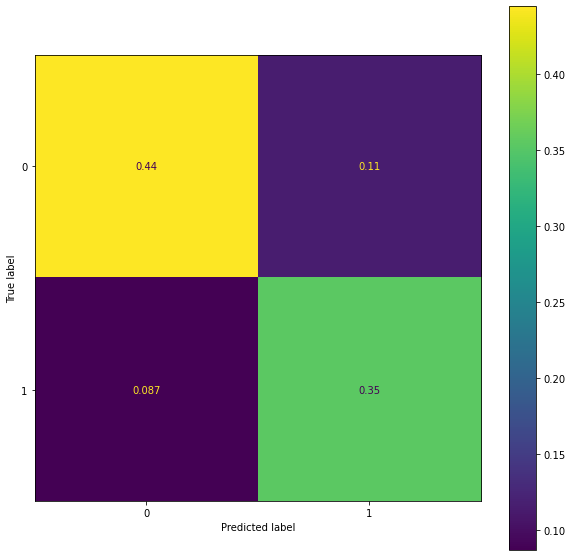

In [58]:
cm = confusion_matrix(y_test, preds, labels=[0, 1] , normalize='all' )
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show();

# Some improvements
We can see that the gridCV search lead to some improvements, even though they were small.